In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the data
data = pd.read_csv('../data/crime_data_cleaned.csv')

data.shape

(549861, 35)

### Building a Data Model
We want to build a model that will serve to influence a metric. The metric we are interested in is the clearance rate of crimes. The clearance rate is the percentage of crimes that are "solved" or "cleared" by the police. A crime is considered cleared when an arrest is made, when a suspect is charged, or when the case is closed in some other way. The clearance rate is calculated by dividing the number of crimes that are cleared by the total number of crimes recorded.




<div style="text-align:center">
    <img src="/Users/danherman/Desktop/los_angeles_crime/images/clearance_rate.png" alt="Clearance Rate" width="900" height="600">
</div>





In [2]:
# calculate the clearance rate for each crime category
clearance_rate = data.loc[ 
                          (data['Status']=='AA')| # set boolean mask for AA (Adult Arrest) using OR operator
                          (data['Status']=='JA') # set boolean mask for JA (Juvenile Arrest)
                          ]['crime_category'].value_counts()/data['crime_category'].value_counts().round(2) 
                        # calculate the clearance rate for each crime category counting Arrests and dividing by total crimes

clearance_rate.to_frame().reset_index().rename(columns={'index':'crime_category','count':'clearance_rate'}).sort_values(by='clearance_rate',ascending=False)

,crime_category,clearance_rate
3,HOMICIDE,0.581064
0,AGGRAVATED ASSAULT,0.233537
7,ROBBERY,0.196637
6,RAPE,0.110393
4,HUMAN TRAFFICKING,0.107143
1,ARSON,0.092247
2,BURGLARY,0.049641
8,THEFT,0.042642
5,MOTOR VEHICLE THEFT,0.030111


### Plot the data

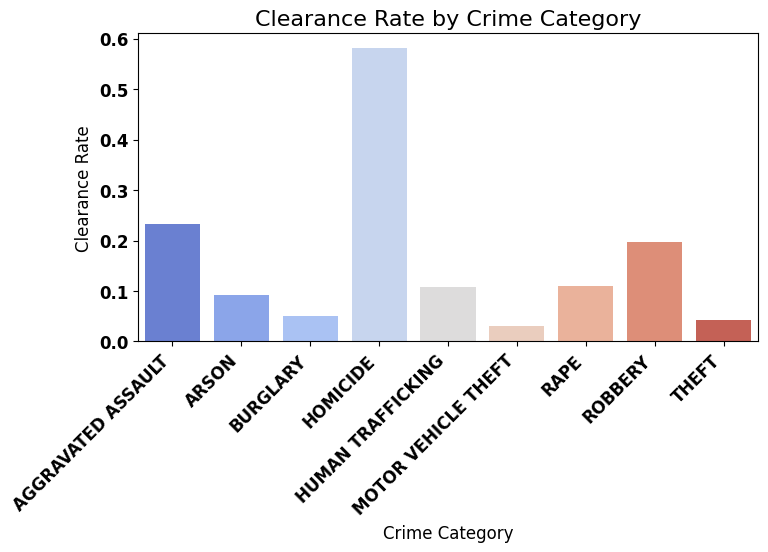

In [3]:
# set run command for font and font weight
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# set the color palette
palette = sns.color_palette("coolwarm", len(clearance_rate))

# create the plot
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=clearance_rate.index, y=clearance_rate.values, ax=ax, palette=palette)
plt.title('Clearance Rate by Crime Category', fontsize=16)
plt.xlabel('Crime Category')
plt.ylabel('Clearance Rate')

# Rotate and align x-axis labels for readability
for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right')

plt.show()

### Create the target variable
The target variable is arrest. We will create a binary variable that indicates whether an arrest was made or not. We will use the 'Arrest' column to create this variable. We will replace the 'True' values with 1 and the 'False' values with 0. We will then calculate the clearance rate by dividing the number of crimes that were cleared by the total number of crimes recorded.


target
0    504964
1     44897
Name: count, dtype: int64

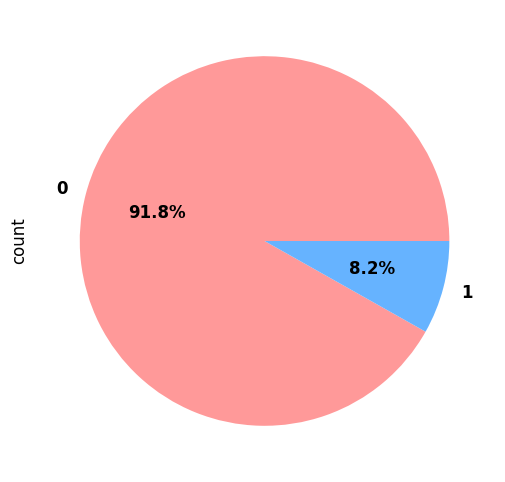

In [24]:
# create target variable - If Arrested Adult Arrest (AA) or Juvenile Arrest (JA) = 1, else 0
data['target'] = data['Status'].apply(lambda x: 1 if x in ['AA', 'JA'] else 0)

display(data['target'].value_counts())
data.target.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), colors=['#ff9999','#66b3ff']);

### There is a huge class imblance.  There are 55,000 observations of arrest, compared to 505,331 observations of no arrest.  This is a class imbalance of 1:10.  We will need to address this in our model.

### We can go deeper into crimes and look at them individually, by severity.

### First we can look into Homicide

In [25]:
# isolate arrests made for Homicide
data.query('crime_category == "HOMICIDE"')['target'].value_counts()

target
1    896
0    646
Name: count, dtype: int64

In [26]:
# create a dataframe for criminal homicide 
homicide = data.query('crime_category == "HOMICIDE"')

In [27]:
# build the model islolating appropriate columns
homicide = homicide.loc[:,['DateRptd', 'DATEOCC', 'TIMEOCC','AREANAME','CrmCdDesc','VictAge','VictSex', 'VictDescent','PremisDesc','WeaponDesc', 'Status','StatusDesc','crime_category','target']]

homicide[:1]

,DateRptd,DATEOCC,TIMEOCC,AREANAME,CrmCdDesc,VictAge,VictSex,VictDescent,PremisDesc,WeaponDesc,Status,StatusDesc,crime_category,target
2317,2020-05-16,2020-05-15,1945,Central,CRIMINAL HOMICIDE,57,M,H,STAIRWELL*,UNKNOWN TYPE CUTTING INSTRUMENT,AA,Adult Arrest,HOMICIDE,1


In [28]:
# fill the nulls in WeaponDesc with ''
homicide['WeaponDesc'] = homicide['WeaponDesc'].fillna('')

homicide.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1542 entries, 2317 to 548655
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DateRptd        1542 non-null   object
 1   DATEOCC         1542 non-null   object
 2   TIMEOCC         1542 non-null   int64 
 3   AREANAME        1542 non-null   object
 4   CrmCdDesc       1542 non-null   object
 5   VictAge         1542 non-null   int64 
 6   VictSex         1540 non-null   object
 7   VictDescent     1540 non-null   object
 8   PremisDesc      1537 non-null   object
 9   WeaponDesc      1542 non-null   object
 10  Status          1542 non-null   object
 11  StatusDesc      1542 non-null   object
 12  crime_category  1542 non-null   object
 13  target          1542 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 180.7+ KB


### We will use NLP to vectorize the words and run a logistic regression model to look at words that lead to arrest
We will look at the following columns:
`PremisDesc` and `WeaponDesc` to see if we can extract any words that can predict the arrest of a crime.
<br>
Here are the steps involved:
1.  Create training and testing data
2.  Vectorize the words
3.  Run a logistic regression model
4.  Look at the words that lead to arrest


In [29]:
# train test split
from sklearn.model_selection import train_test_split

X = homicide[['WeaponDesc']]
y = homicide['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

(1233, 1)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


# create the vectorizer
vectorizer = TfidfVectorizer(
                             stop_words='english',
                             max_features=200,
                             min_df=0.001
                             )

# fit the vectorizer
X_train_tfidf = vectorizer.fit_transform(X_train['WeaponDesc'])

# transform the test data
X_test_tfidf = vectorizer.transform(X_test['WeaponDesc'])

X_train_tfidf.shape, X_test_tfidf.shape


[nltk_data] Downloading package punkt to /Users/danherman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danherman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danherman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


((1233, 40), (309, 40))

### Scale The Data

In [31]:
# scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

X_train_tfidf_scaled.shape, X_test_tfidf_scaled.shape

((1233, 40), (309, 40))

### Fit the model

In [32]:
# build the model
from sklearn.linear_model import LogisticRegression

# instantiate the model
model = LogisticRegression()

# fit the model
model.fit(X_train_tfidf_scaled, y_train)

# make predictions
y_pred = model.predict(X_test_tfidf_scaled)


### Evaluate the fitted model

In [33]:

# evaluate the model
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.41      0.05      0.09       134
           1       0.57      0.94      0.71       175

    accuracy                           0.56       309
   macro avg       0.49      0.50      0.40       309
weighted avg       0.50      0.56      0.44       309



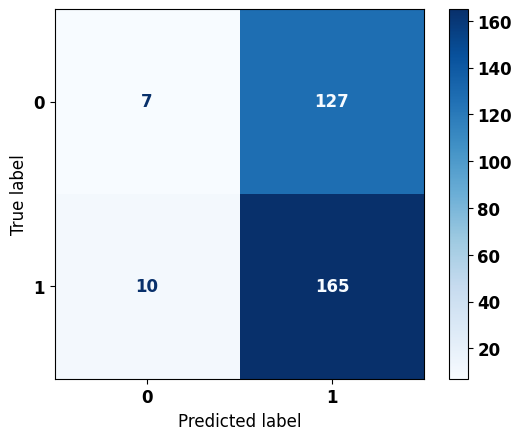

In [34]:

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

plt.show()


In [35]:
# create df with coefs and features
coefs = model.coef_.flatten()
features = vectorizer.get_feature_names_out()

coefs_df = pd.DataFrame({'feature': features, 'coef': coefs})

coefs_df = coefs_df.sort_values(by='coef', ascending=True)

bottom_20_words = coefs_df[:20]

top_20_words = coefs_df[-20:]

Text(0.5, 0.98, 'Bottom 20 Words associated with an arrest')

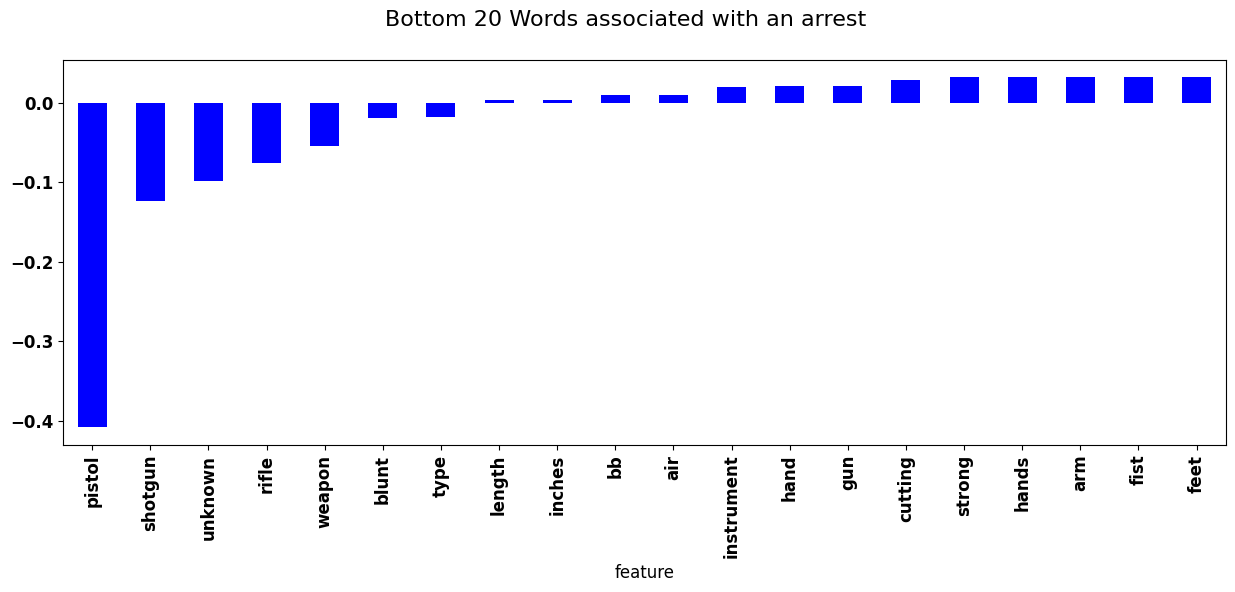

In [36]:
bottom_20_words.sort_values(by='coef', ascending=True, inplace=True)

bottom_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Bottom 20 Words associated with an arrest', fontsize=16)

Text(0.5, 0.98, 'Top 20 Words Associated with Homicide Arrests')

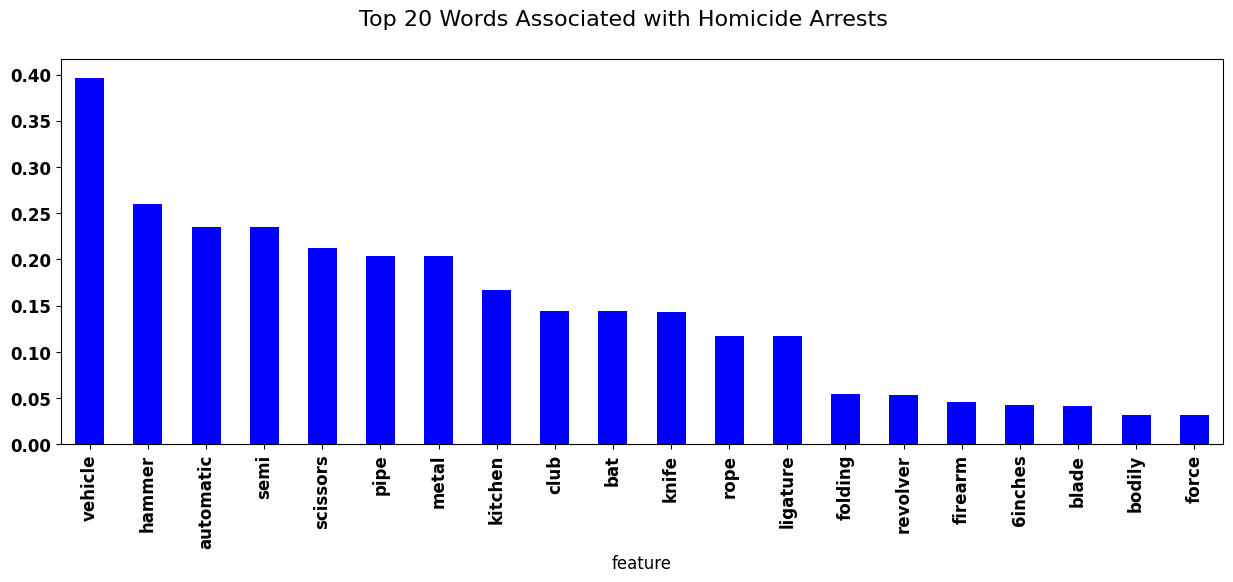

In [37]:
# plot top 20 words
top_20_words.sort_values(by='coef', ascending=False, inplace=True)

top_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Top 20 Words Associated with Homicide Arrests', fontsize=16)
plt.xticks(rotation=45)


### Let's apply the same rigor to PremisDesc

In [39]:
# resolve the nulls
homicide['PremisDesc'] = homicide['PremisDesc'].fillna('')


In [40]:
# train test split
from sklearn.model_selection import train_test_split

X = homicide[['PremisDesc']]
y = homicide['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

(1233, 1)

### Vectorize the words

In [41]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


# create the vectorizer
vectorizer = TfidfVectorizer(
                             stop_words='english',
                             max_features=200,
                             min_df=0.001
                             )

# fit the vectorizer
X_train_tfidf = vectorizer.fit_transform(X_train['PremisDesc'])

# transform the test data
X_test_tfidf = vectorizer.transform(X_test['PremisDesc'])

X_train_tfidf.shape, X_test_tfidf.shape


[nltk_data] Downloading package punkt to /Users/danherman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danherman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danherman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


((1233, 80), (309, 80))

### Scale the data

In [42]:
scaler = StandardScaler(with_mean=False)

X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

X_train_tfidf_scaled.shape, X_test_tfidf_scaled.shape

((1233, 80), (309, 80))

### Fit the model

In [43]:
# instantiate the model
model = LogisticRegression()

# fit the model
model.fit(X_train_tfidf_scaled, y_train)

# make predictions
y_pred = model.predict(X_test_tfidf_scaled)


### Evaluate the fitted model

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.09      0.16       134
           1       0.58      0.95      0.72       175

    accuracy                           0.58       309
   macro avg       0.59      0.52      0.44       309
weighted avg       0.59      0.58      0.48       309



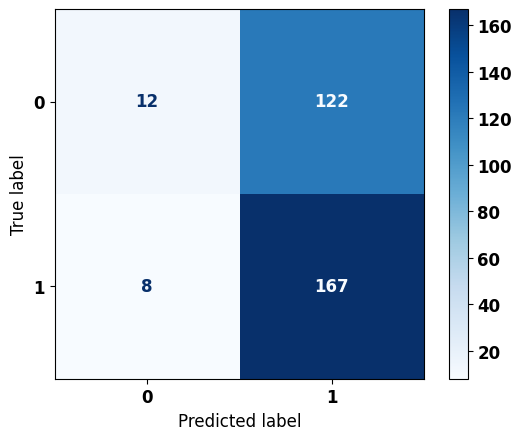

In [45]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

plt.show()


### Evaluate the coefficients

In [46]:
# create df with coefs and features
coefs = model.coef_.flatten()
features = vectorizer.get_feature_names_out()

coefs_df = pd.DataFrame({'feature': features, 'coef': coefs})

coefs_df = coefs_df.sort_values(by='coef', ascending=True)

bottom_20_words = coefs_df[:20]

top_20_words = coefs_df[-20:]

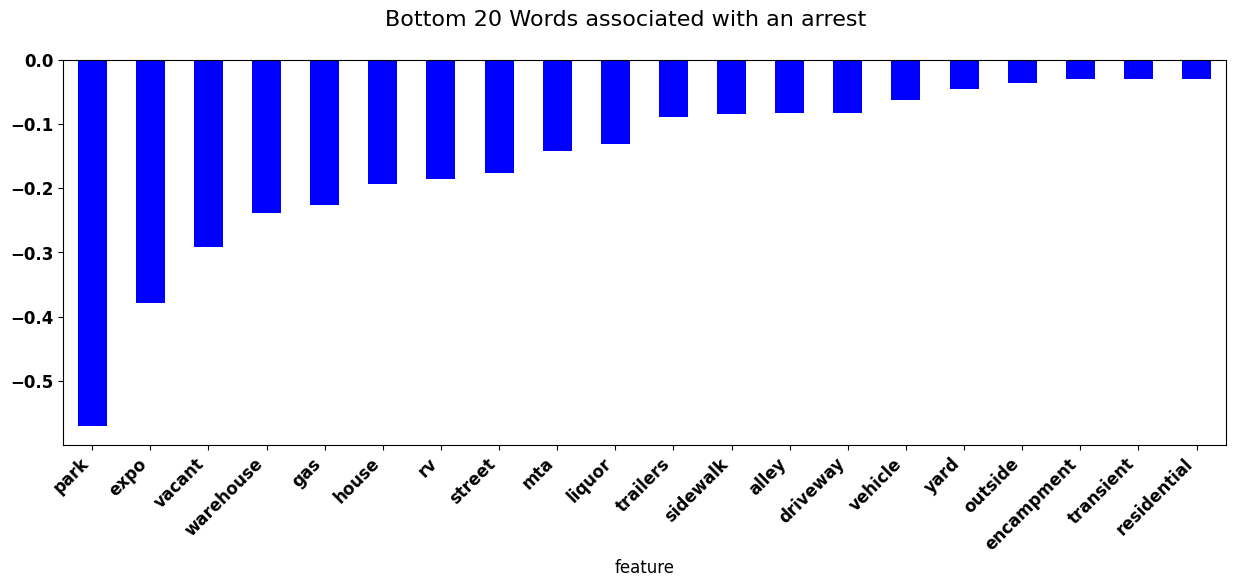

In [60]:
bottom_20_words.sort_values(by='coef', ascending=True, inplace=True)

bottom_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Bottom 20 Words associated with an arrest', fontsize=16)
# align x-axis labels for readability
plt.xticks(rotation=45, ha='right');

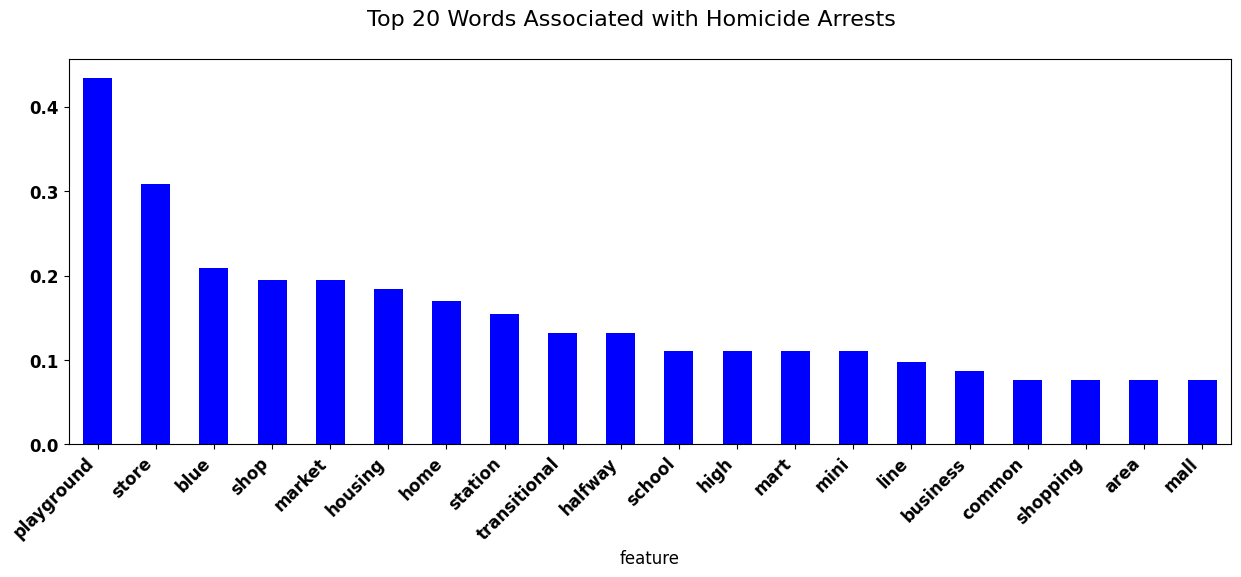

In [58]:
# plot top 20 words
top_20_words.sort_values(by='coef', ascending=False, inplace=True)

top_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Top 20 Words Associated with Homicide Arrests', fontsize=16)
# align the labels 
plt.xticks(rotation=45, ha='right');
    
